In [21]:
# Tabular-Based Approach
dataset_path = "gtzan-dataset-music-genre-classification/Data/genres_original"

PROBLEMATIC_FILES = [
    'jazz.00054.wav',
    'jazz.00064.wav',
]

# function to extract features
import librosa
import librosa.display
import numpy as np
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        return mfcc_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [15]:
# build dataset
import os
genres = os.listdir(dataset_path)
features = []
labels = []

for genre in genres:
    genre_path = os.path.join(dataset_path, genre)
    for file in os.listdir(genre_path):
        if file in PROBLEMATIC_FILES:
            continue
        file_path = os.path.join(genre_path, file)
        data = extract_features(file_path)
        if data is not None:
            features.append(data)
            labels.append(genre)

X = np.array(features)
y = np.array(labels)

In [16]:
# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42,stratify=y)

In [17]:
# scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# train multi-classification models
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

from sklearn.svm import SVC
svc = SVC(kernel="rbf")
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [19]:
# evaluate model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_svc = accuracy_score(y_test, y_pred_svc)

print("Accuracy Results")
print("\nLogistic Regression: ", accuracy_lr)
print("\nSVC: ", accuracy_svc)

Accuracy Results

Logistic Regression:  0.56

SVC:  0.61


In [22]:
# predict genre
def predict_genre(file_path, model, scaler):
    data = extract_features(file_path)
    if data is None:
        return "Error: Could not process file."
    data = scaler.transform([data])
    prediction = model.predict(data)
    return prediction[0]

my_own_audio_file = "test_song.wav"
if os.path.exists(my_own_audio_file):
    predicted_genre = predict_genre(my_own_audio_file, log_reg, scaler)
    print(f"Predicted Genre - logistic regression: {predicted_genre}")
    predicted_genre = predict_genre(my_own_audio_file, svc, scaler)
    print(f"Predicted Genre - SVC: {predicted_genre}")
else:
    print("Test file not found, skiping prediction.")

Predicted Genre - logistic regression: rock
Predicted Genre - SVC: rock


In [31]:
# Image-Based Approach
def audio_to_melspectrogram(file_path, max_len=128):
    y, sr = librosa.load(file_path, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    # resize the images to a fixed shape such as 128 x 128
    if S_db.shape[1] < max_len:
        pad_width = max_len - S_db.shape[1]
        S_db = np.pad(S_db, pad_width=((0,0), (0,pad_width)), mode="constant")
    else:
        S_db = S_db[:, :max_len]
    return S_db

In [37]:
# build dataset
dataset_path = "gtzan-dataset-music-genre-classification/Data/genres_original"
genres = os.listdir(dataset_path)
data = []
labels = []

for genre in genres:
    genre_path = os.path.join(dataset_path, genre)
    for file in os.listdir(genre_path):
        if file in PROBLEMATIC_FILES:
            continue
        file_path = os.path.join(genre_path, file)
        try:
            spec = audio_to_melspectogram(file_path)
            data.append(spec)
            labels.append(genre)
        except:
            continue
X = np.array(data)
y = np.array(labels)

X = X[..., np.newaxis]

In [38]:
# encode labels
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
en = LabelEncoder()
y_en = en.fit_transform(y)
y_en = tf.keras.utils.to_categorical(y_en, num_classes=len(genres))

In [42]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [43]:
# CNN model
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(genres), activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,354 (12.61 MB)

 Trainable params: 3,305,354 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# train
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - accuracy: 0.1002 - loss: 7.2595 - val_accuracy: 0.1250 - val_loss: 2.3143
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - accuracy: 0.1095 - loss: 2.3077 - val_accuracy: 0.1312 - val_loss: 2.2801
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.1471 - loss: 2.2709 - val_accuracy: 0.1562 - val_loss: 2.2388
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 461ms/step - accuracy: 0.2191 - loss: 2.1983 - val_accuracy: 0.2438 - val_loss: 2.1749
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - accuracy: 0.2723 - loss: 2.0704 - val_accuracy: 0.3375 - val_loss: 1.9697
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 512ms/step - accuracy: 0.3146 - loss: 1.9149 - val_accuracy: 0.4000 - val_loss: 1.7881
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.3709 - loss: 1.8036 - val_accuracy: 0.4437 - val_loss: 1.7397
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 604ms/step - accuracy: 0.3599 - loss: 1.7147 - val_accura

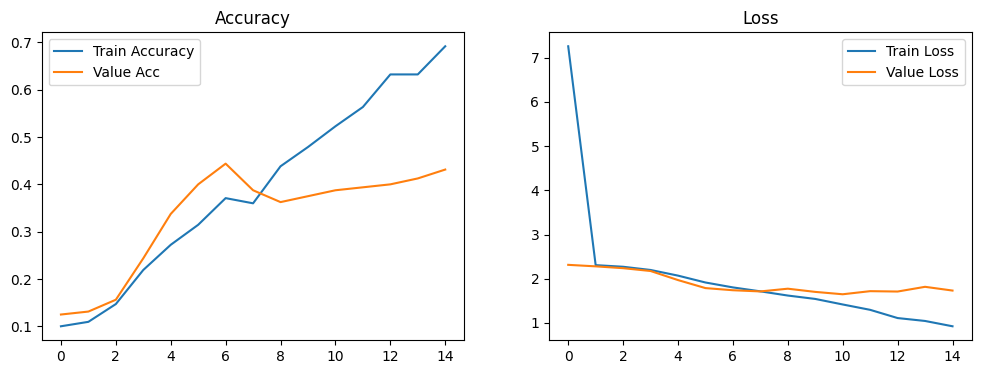

In [46]:
# plot training
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Value Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Value Loss")
plt.legend()
plt.title("Loss")
plt.show()

Audio: jazz.00037.wav
Actual genre: jazz


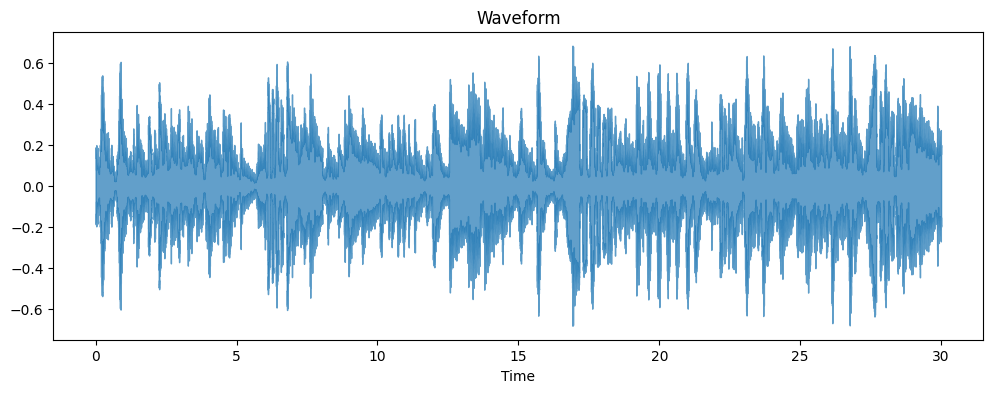

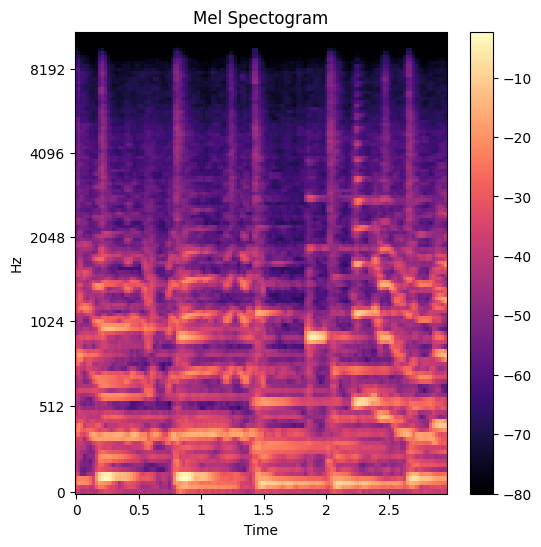

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted genre: jazz


In [51]:
# now test and train my own audio
import random
def predict_random_audio():
    random_genre = random.choice(genres)
    random_file = random.choice(os.listdir(os.path.join(dataset_path, random_genre)))
    file_path = os.path.join(dataset_path, random_genre, random_file)
    print(f"Audio: {random_file}")
    print(f"Actual genre: {random_genre}")

    # show waveform
    y,sr = librosa.load(file_path, duration=30)
    plt.figure(figsize=(12,4))
    librosa.display.waveshow(y,sr=sr, alpha=0.7)
    plt.title("Waveform")
    plt.show()

    # show spectogram
    spec = audio_to_melspectrogram(file_path)
    plt.figure(figsize=(6,6))
    librosa.display.specshow(spec, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar()
    plt.title("Mel Spectogram")
    plt.show()

    spec_input = spec[np.newaxis, ..., np.newaxis]
    prediction = model.predict(spec_input)
    predicted_genre = encoder.inverse_transform([np.argmax(prediction)])[0]
    print(f"Predicted genre: {predicted_genre}")

predict_random_audio()

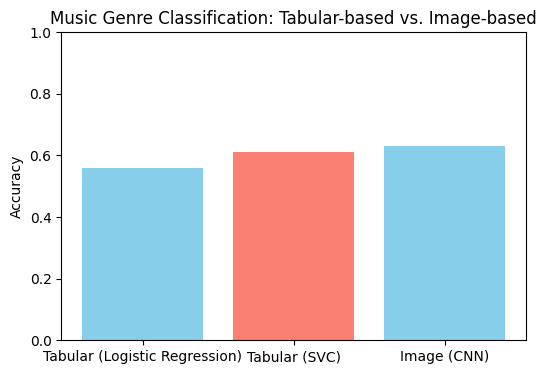

In [89]:
# compare the results of both approaches
methods = ['Tabular (Logistic Regression)', 'Tabular (SVC)', 'Image (CNN)']
accuracies = [accuracy_lr, accuracy_svc , history.history['val_accuracy'][-1]]
plt.figure(figsize=(6,4))
plt.bar(methods, accuracies, color=['skyblue','salmon'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Music Genre Classification: Tabular-based vs. Image-based")
plt.show()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 214s 11s/step - accuracy: 0.1862 - loss: 3.0016 - val_accuracy: 0.3125 - val_loss: 1.8887
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 201s 10s/step - accuracy: 0.3396 - loss: 1.8434 - val_accuracy: 0.4563 - val_loss: 1.5622
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.3991 - loss: 1.6570 - val_accuracy: 0.5063 - val_loss: 1.4760
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 197s 10s/step - accuracy: 0.4679 - loss: 1.4559 - val_accuracy: 0.5000 - val_loss: 1.3453
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 244s 12s/step - accuracy: 0.4820 - loss: 1.4625 - val_accuracy: 0.5375 - val_loss: 1.2865
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 215s 11s/step - accuracy: 0.5039 - loss: 1.3742 - val_accuracy: 0.5688 - val_loss: 1.3411
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 204s 10s/step - accuracy: 0.5086 - loss: 1.3125 - val_accuracy: 0.5125 - val_loss: 1.2334
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 198s 10s/step - accuracy: 0.5430 - loss: 1.3168 - val_accuracy: 0.

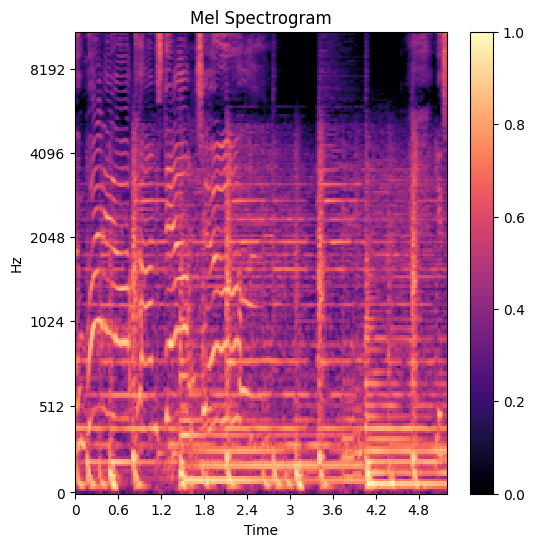

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Predicted Genre: pop


In [88]:
# bonus: using transfer learning on spectrograms
from tensorflow.keras.applications import VGG16
def audio_to_melspectrogram(file_path, max_len=224):
    y, sr = librosa.load(file_path, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=224)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    if S_dB.shape[1] < max_len:
        pad_width = max_len - S_dB.shape[1]
        S_dB = np.pad(S_dB, pad_width=((0,0),(0,pad_width)), mode="constant")
    else:
        S_dB = S_dB[:, :max_len]
        
    S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
    S_img = np.stack([S_dB]*3, axis=-1)
    
    return S_img

# build dataset
dataset_path = "gtzan-dataset-music-genre-classification/Data/genres_original"
genres = os.listdir(dataset_path)

data, labels = [], []

for genre in genres:
    genre_path = os.path.join(dataset_path, genre)
    for file in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file)
        try:
            spec = audio_to_melspectrogram(file_path)
            data.append(spec)
            labels.append(genre)
        except:
            continue

X = np.array(data)
y = np.array(labels)

# encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = tf.keras.utils.to_categorical(y_encoded, num_classes=len(genres))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# load Pretrained VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base model layers (don’t train them at first)
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(genres), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# predict Random Song
# ---------------------------
def predict_random_song():
    random_genre = random.choice(genres)
    random_file = random.choice(os.listdir(os.path.join(dataset_path, random_genre)))
    file_path = os.path.join(dataset_path, random_genre, random_file)

    print(f"\nSong: {random_file}")
    print(f"\nActual Genre: {random_genre}")

    # Show spectrogram
    spec = audio_to_melspectrogram(file_path)
    plt.figure(figsize=(6,6))
    librosa.display.specshow(spec[:,:,0], sr=22050, x_axis="time", y_axis="mel")
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.show()

    # predict
    spec_input = spec[np.newaxis, ...]
    prediction = model.predict(spec_input)
    predicted_genre = encoder.inverse_transform([np.argmax(prediction)])[0]

    print(f"\nPredicted Genre: {predicted_genre}")

predict_random_song()
